In [1]:
import numpy as np
import os
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')

import matplotlib.pyplot as plt # for plotting
%matplotlib widget
import pandas as pd # for data manipulation
from Models.load_data import *
from Models.helpers import *

%load_ext autoreload
%autoreload 2

import torch

path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Training_data'
features_list = os.listdir(os.path.join(path, r'features'))

In [28]:
# This cell takes 19s
# Instantiate the dataset without transformations
dataset = IndependentCSVDataset(path, features_list)

# Split dataset into training and testing sets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

feature_min, feature_max = compute_global_minmax(train_dataset)
print("Global feature min (train set only):", feature_min)
print("Global feature max (train set only):", feature_max)

global_transform = GlobalMinMaxNormalize(feature_min, feature_max)
train_dataset.dataset.transform = global_transform
test_dataset.dataset.transform = global_transform  # Same transform to prevent data leakage

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)



Global feature min (train set only): [ 0.0000000e+00 -3.5055832e+06 -9.1752766e+13  0.0000000e+00
 -8.4846081e+13  0.0000000e+00  0.0000000e+00 -3.5051655e+06
 -9.2097940e+13  0.0000000e+00 -7.3527542e+13  0.0000000e+00
  0.0000000e+00 -3.5073330e+06 -9.2103753e+13  0.0000000e+00
 -7.2064157e+13  0.0000000e+00  0.0000000e+00 -3.5088230e+06
 -9.1307901e+13  0.0000000e+00 -9.4136540e+13  0.0000000e+00
  0.0000000e+00 -3.5077160e+06 -9.0980284e+13  0.0000000e+00
 -8.5559138e+13  0.0000000e+00  0.0000000e+00 -3.5052565e+06
 -9.0181126e+13  0.0000000e+00 -9.5513295e+13  0.0000000e+00
  0.0000000e+00 -3.5047762e+06 -1.0885503e+14  0.0000000e+00
 -7.5441352e+13  0.0000000e+00  0.0000000e+00 -3.5020450e+06
 -9.0598057e+13  0.0000000e+00 -8.6843157e+13  0.0000000e+00
  0.0000000e+00 -3.4991772e+06 -9.0174390e+13  0.0000000e+00
 -8.3978229e+13  0.0000000e+00  0.0000000e+00 -3.5018470e+06
 -8.9870127e+13  0.0000000e+00 -8.4611669e+13  0.0000000e+00
  0.0000000e+00 -3.5028985e+06 -9.0597663e+13  0

In [32]:
# Create an iterator from the DataLoader
train_iterator = iter(train_loader)

# Get a single batch
batch = next(train_iterator)

# Unpack the batch (assuming your dataset returns (inputs, targets))
inputs, targets = batch

print("Inputs shape:", inputs.shape)
print("Targets shape:", targets.shape)


Inputs shape: torch.Size([32, 60, 600])
Targets shape: torch.Size([32, 60, 100])


## Training the model

In [33]:
# Define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss(pos_weight=compute_class_weights(train_loader))
# Define the model and print the architecture, example with dummy input shapes
# [I 2025-02-07 01:30:51,832] Trial 37 finished with value: 1.143294748031732 and parameters: 
# {'hidden_size': 401, 'dropout': 0.31159803520368773, 'learning_rate': 0.0004282581786099833, 
# 'weight_decay': 3.0769712937166838e-06}. Best is trial 37 with value: 1.143294748031732.

input_size = 600       # Number of features per time step
hidden_size = 401     # Number of LSTM hidden units
num_layers = 2       # Number of LSTM layers
output_size = 100      # Binary classification
dropout = 0.31159803520368773

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)

# Print model architecture
print(model)

# Example dummy input: batch_size=32, sequence_length=6000, input_size=6
dummy_input = inputs
dummy_output = model(dummy_input)

print("Input shape:", dummy_input.shape)  # Expected: (32, 6000, 6) -> 6 features per timestep
print("Output shape:", dummy_output.shape)  # Expected: (32, 6000,) -> one binary value per timestep
print("Targets shape:", targets.shape)

loss = criterion(dummy_output, targets)

print(loss.item())

LSTMModel(
  (lstm): LSTM(600, 401, num_layers=2, batch_first=True, dropout=0.31159803520368773)
  (fc1): Linear(in_features=401, out_features=401, bias=True)
  (fc2): Linear(in_features=401, out_features=100, bias=True)
  (sigmoid): Sigmoid()
)
Input shape: torch.Size([32, 60, 600])
Output shape: torch.Size([32, 60, 100])
Targets shape: torch.Size([32, 60, 100])
1.4426698684692383


In [ ]:
# Define the optimizer
import torch
import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=0.0004282581786099833, weight_decay=3.0769712937166838e-06)

# Assume `train_loader` is a DataLoader yielding batches of (input, target)
num_epochs = 20

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        print(f'Accumulated epoch loss: {epoch_loss:.4f}, {batch_idx=}', end='\r')
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\lstm_model.pth')
print('Model saved at C:\\Users\\Max Tost\\Desktop\\Notebooks\\SPC Neural Network Project\\Models\\lstm_model.pth')


Epoch [1/20], Loss: 1.3724.9794, batch_idx=7
Epoch [2/20], Loss: 1.5791.6327, batch_idx=7
Epoch [3/20], Loss: 1.3201.5605, batch_idx=7
Epoch [4/20], Loss: 1.3248.5987, batch_idx=7
Epoch [5/20], Loss: 1.3475.7803, batch_idx=7
Epoch [6/20], Loss: 1.4990.9918, batch_idx=7
Epoch [7/20], Loss: 1.4537.6298, batch_idx=7
Epoch [8/20], Loss: 1.4650.7198, batch_idx=7
Epoch [9/20], Loss: 1.2846.2771, batch_idx=7
Epoch [10/20], Loss: 1.2258067, batch_idx=7
Epoch [11/20], Loss: 1.29533625, batch_idx=7
Epoch [12/20], Loss: 1.1767135, batch_idx=7
Epoch [13/20], Loss: 1.2092738, batch_idx=7
Epoch [14/20], Loss: 1.0732852, batch_idx=7
Epoch [15/20], Loss: 1.2329635, batch_idx=7
Epoch [16/20], Loss: 1.47968369, batch_idx=7
Epoch [17/20], Loss: 1.41873496, batch_idx=7
Epoch [18/20], Loss: 1.37950361, batch_idx=7
Epoch [19/20], Loss: 1.29503598, batch_idx=7
Epoch [20/20], Loss: 1.34857877, batch_idx=7


## Plotting outputs of model

In [34]:
# Parameters:
input_size = 600       # Number of features per time step
hidden_size = 401     # Number of LSTM hidden units
num_layers = 2       # Number of LSTM layers
output_size = 100      # Binary classification
dropout = 0.31159803520368773

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
model.load_state_dict(torch.load(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\lstm_model.pth', weights_only=True))
model.eval()

LSTMModel(
  (lstm): LSTM(600, 401, num_layers=2, batch_first=True, dropout=0.31159803520368773)
  (fc1): Linear(in_features=401, out_features=401, bias=True)
  (fc2): Linear(in_features=401, out_features=100, bias=True)
  (sigmoid): Sigmoid()
)

In [39]:
# Create an iterator from the DataLoader
train_iterator = iter(train_loader)

# Get a single batch
batch = next(train_iterator)

# Unpack the batch (assuming your dataset returns (inputs, targets))
inputs, targets = batch
input, target = inputs[0], targets[0]

print("Inputs shape:", input.shape)
print("Targets shape:", target.shape)

output = model(input)

print("Outputs shape:", output.shape)

Inputs shape: torch.Size([60, 600])
Targets shape: torch.Size([60, 100])
Outputs shape: torch.Size([60, 100])


In [52]:
torch.sum(outputs)

tensor(-39632.2656, grad_fn=<SumBackward0>)

Inputs shape: torch.Size([60, 600])
Targets shape: torch.Size([60, 100])
Outputs shape: torch.Size([60, 100])


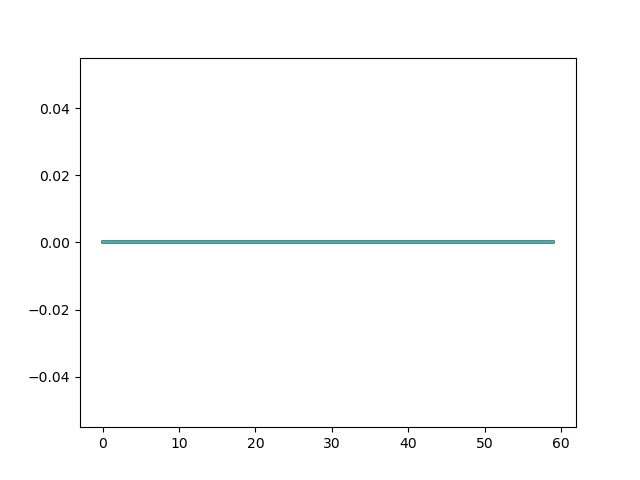

In [47]:
k = 1
# Unpack the batch (assuming your dataset returns (inputs, targets))
inputs, targets = batch
input, target = inputs[k], targets[k]

print("Inputs shape:", input.shape)
print("Targets shape:", target.shape)

output = model(input)

print("Outputs shape:", output.shape)
target_reshaped = target.reshape(60, 100)
target_original = target_reshaped.reshape(6000)
target_original
plt.close()
plt.plot(target, label="Target")

## Hyperparameter Tuning

In [18]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Your dataset should be defined before running Optuna
dataset = ...  # Your dataset should be a PyTorch Dataset object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 1: Define K-Fold Cross-Validation**
def get_kfold_splits(dataset, k=3):
    """
    Splits dataset into k folds for cross-validation.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    indices = list(range(len(dataset)))
    return [(list(train_idx), list(val_idx)) for train_idx, val_idx in kf.split(indices)]

# **Step 2: Define Optuna Objective Function**
def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning with K-Fold cross-validation.
    """
    # **Suggest Hyperparameters**
    hidden_size = trial.suggest_int("hidden_size", 64, 512)
    num_layers = 2
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    
    # **Cross-Validation Setup**
    k = 3  # Number of folds
    path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Training_data'
    features_list = os.listdir(os.path.join(path, r'features'))
    # Loading the dataset for this fold
    dataset = IndependentCSVDataset(path, features_list)
    splits = get_kfold_splits(dataset, k)
    fold_losses = []  # Store loss for each fold

    for fold, (train_idx, val_idx) in enumerate(splits):
        # print(f"Training Fold {fold+1}/{k}")
        

        # **Subset datasets for this fold**
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        feature_min, feature_max = compute_global_minmax(train_subset)

        global_transform = GlobalMinMaxNormalize(feature_min, feature_max)
        train_subset.dataset.transform = global_transform
        val_subset.dataset.transform = global_transform  # Same transform to prevent data leakage

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)


        # **Create LSTM Model**
        model = LSTMModel(input_size=600, hidden_size=hidden_size, num_layers=num_layers, output_size=100, dropout=dropout)
        model.to(device)

        # **Loss & Optimizer**
        criterion = nn.BCEWithLogitsLoss(pos_weight=compute_class_weights(train_loader))
        optimizer = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
        )

        # **Training Loop**
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())
                loss.backward()
                optimizer.step()

        # **Validation Loss for Fold**
        model.eval()
        val_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets.float())

                val_loss += loss.item() * inputs.size(0)
                total_samples += inputs.size(0)

        avg_val_loss = val_loss / total_samples
        fold_losses.append(avg_val_loss)

    # **Return the mean validation loss across all folds**
    mean_loss = sum(fold_losses) / len(fold_losses)
    return mean_loss

# **Step 3: Run Optuna Optimization**
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=60)

# **Step 4: Best Hyperparameters**
print("Best trial:")
print(f"  Validation Loss: {study.best_trial.value:.4f}")
print("  Params:", study.best_trial.params)


[I 2025-02-06 19:12:12,255] A new study created in memory with name: no-name-7d42ee83-9fce-41ff-9fab-897202957042
[I 2025-02-06 19:14:22,773] Trial 0 finished with value: 1.4831497163893161 and parameters: {'hidden_size': 68, 'dropout': 0.2796572278236362, 'learning_rate': 0.004450825657499489, 'weight_decay': 0.00027124720064343276}. Best is trial 0 with value: 1.4831497163893161.
[I 2025-02-06 19:27:39,277] Trial 1 finished with value: 1.6296354915066404 and parameters: {'hidden_size': 364, 'dropout': 0.49295518977565567, 'learning_rate': 0.006043435602079738, 'weight_decay': 0.007852530176627527}. Best is trial 0 with value: 1.4831497163893161.
[I 2025-02-06 19:41:36,139] Trial 2 finished with value: 1.2608569962645957 and parameters: {'hidden_size': 365, 'dropout': 0.4004909576509085, 'learning_rate': 0.0006279622666646788, 'weight_decay': 4.0703178450966685e-06}. Best is trial 2 with value: 1.2608569962645957.
[I 2025-02-06 19:49:44,332] Trial 3 finished with value: 1.377703879061

Best trial:
  Validation Loss: 1.1433
  Params: {'hidden_size': 401, 'dropout': 0.31159803520368773, 'learning_rate': 0.0004282581786099833, 'weight_decay': 3.0769712937166838e-06}


In [ ]:
# Bayesian optimization
import BayesianOptimization as bo

In [32]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

def evaluate_test_metrics(model, test_loader, criterion, device, threshold=0.5):
    """
    Evaluates the test loss, F1-score, and ROC-AUC of a trained model.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: Loss function (e.g., nn.BCEWithLogitsLoss).
    - device: The device ('cuda' or 'cpu').
    - threshold: Decision threshold for binary classification (default=0.5).

    Returns:
    - Average test loss
    - F1-score
    - ROC-AUC score
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    total_samples = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

            # Forward pass
            outputs = model(inputs)  # (batch_size, 6000) -> raw logits

            # Compute loss
            loss = criterion(outputs, targets)  # BCEWithLogitsLoss expects raw logits
            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            # Convert logits to probabilities using Sigmoid
            probs = torch.sigmoid(outputs)  # (batch_size, 6000) -> probabilities in [0,1]

            # Apply threshold to get binary predictions
            preds = (probs > threshold).int()  # Convert to 0 or 1

            # Flatten for metric calculations
            all_targets.extend(targets.cpu().numpy().flatten())  # Convert to 1D list
            all_predictions.extend(preds.cpu().numpy().flatten())  # Convert to 1D list

    # Compute average loss
    avg_test_loss = test_loss / total_samples

    # Compute F1-score
    f1 = f1_score(all_targets, all_predictions, average='macro')

    return avg_test_loss, f1

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_f1 = evaluate_test_metrics(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Test Loss: 8.1832
F1 Score: 0.0170
